In [1]:
import iris
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import iris.quickplot as qplt
import iris.plot as iplt
import datetime
import shutil
from pathlib import Path
import trackpy
from iris.time import PartialDateTime
import cartopy.crs as ccrs
import xarray as xr
import netCDF4 as nc
import scipy
from scipy import ndimage
from scipy.ndimage import label, generate_binary_structure

#import packages that output memory usage:
#from sys import getsizeof

import tobac #tobac package cloned from https://github.com/tobac-project/tobac.git

import warnings
warnings.filterwarnings('ignore')

In [94]:
filelist_v_hindcast = '/scratch/hgilmour/cpm_HINDCAST/v_wind/*.pp'
filelist_u_hindcast = '/scratch/hgilmour/cpm_HINDCAST/u_wind/*.pp'

v_wind_hindcast = iris.load(filelist_v_hindcast)
u_wind_hindcast = iris.load(filelist_u_hindcast)

u_wind_hindcast = u_wind_hindcast[0]
v_wind_hindcast = v_wind_hindcast[0]

In [95]:
v_wind_hindcast = v_wind_hindcast[:,:,1:,:]
u_wind_hindcast = u_wind_hindcast[:,:,1:,:]


In [102]:
era5_wind = iris.load('/scratch/hgilmour/obs/u_v_wind/era5_u_v_winds_2001_2007.nc')

u_wind_era5 = era5_wind[0][:24,:,:,20:] ## :24 for just 2001-2002, 20: to remove 90-85W of longitude
v_wind_era5 = era5_wind[1][:24,:,:,20:]
v_wind_era5

<iris 'Cube' of northward_wind / (m s**-1) (time: 24; pressure_level: 4; latitude: 221; longitude: 221)>

In [115]:
## now need to regrid cpm to era5 grid to make difference plots
# Write a function which creates bounds and a coordinate system for a cube (for lat lon named cubes)
def guesslatlonbounds_latlon(cube):
    cube.coord('longitude').circular = True

    cs = iris.coord_systems.GeogCS(6371229)
    for coord in ['latitude','longitude']:
        if cube.coord(coord).bounds is None:
            cube.coord(coord).guess_bounds()
        if cube.coord(coord).coord_system is None:
            cube.coord(coord).coord_system = cs
            
    return cube


def regrid(cpm_wind, era5_coords):
    scheme = iris.analysis.AreaWeighted()

    regridded_wind =cpm_wind.regrid(era5_coords, scheme)

    return regridded_wind

In [116]:
# Create bounds and a coord system for the IMERG dataset
u_wind_era5_coords = guesslatlonbounds_latlon(u_wind_era5)
v_wind_era5_coords = guesslatlonbounds_latlon(v_wind_era5)
v_wind_hindcast_coords = guesslatlonbounds_latlon(v_wind_hindcast)
u_wind_hindcast_coords = guesslatlonbounds_latlon(u_wind_hindcast)


In [121]:
regridded_u_wind_hindcast = regrid(u_wind_hindcast_coords, u_wind_era5_coords)
regridded_v_wind_hindcast = regrid(v_wind_hindcast_coords, v_wind_era5_coords)

In [122]:
regridded_v_wind_hindcast

<iris 'Cube' of y_wind / (m s-1) (time: 24; pressure: 4; latitude: 221; longitude: 221)>

In [124]:
## save the regridded hindcast files as netcdf

# iris.save(regridded_u_wind_hindcast, '/scratch/hgilmour/cpm_HINDCAST/u_wind/regridded_u_wind_2001_2002.nc')
# iris.save(regridded_v_wind_hindcast, '/scratch/hgilmour/cpm_HINDCAST/v_wind/regridded_v_wind_2001_2002.nc')

In [132]:
u_wind_hindcast = xr.open_dataset('/scratch/hgilmour/cpm_HINDCAST/u_wind/regridded_u_wind_2001_2002.nc')
v_wind_hindcast = xr.open_dataset('/scratch/hgilmour/cpm_HINDCAST/v_wind/regridded_v_wind_2001_2002.nc')

In [133]:
era5_wind = xr.open_dataset('/scratch/hgilmour/obs/u_v_wind/era5_u_v_winds_2001_2007.nc')

u_wind_era5 = era5_wind.u[:24,:,:,20:] ## :24 for just 2001-2002, 20: to remove 90-85W of longitude
v_wind_era5 = era5_wind.v[:24,:,:,20:]
v_wind_era5

<xarray.DataArray 'v' (time: 24, level: 4, latitude: 221, longitude: 221)>
[4688736 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 -85.0 -84.75 -84.5 ... -30.5 -30.25 -30.0
  * latitude   (latitude) float32 15.0 14.75 14.5 14.25 ... -39.5 -39.75 -40.0
  * level      (level) int32 250 500 700 850
  * time       (time) datetime64[ns] 2001-01-01 2001-02-01 ... 2002-12-01
Attributes:
    units:          m s**-1
    long_name:      V component of wind
    standard_name:  northward_wind

In [135]:
# u_wind_hindcast = u_wind_hindcast.x_wind
u_wind_hindcast = u_wind_hindcast.x_wind

In [137]:
v_wind_hindcast = v_wind_hindcast.y_wind

In [138]:
u_wind_hindcast_mean = u_wind_hindcast.mean(dim='time')
v_wind_hindcast_mean = v_wind_hindcast.mean(dim='time')

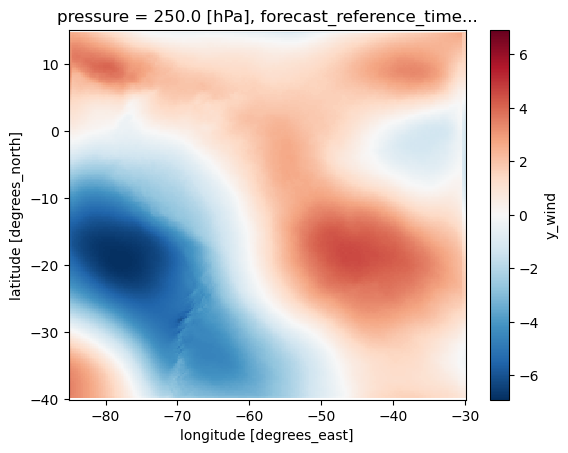

In [148]:
v_wind_hindcast_mean[0,:,:].where(v_wind_hindcast_mean[0,:,:] < 100).plot()

In [140]:
u_wind_era5_mean = u_wind_era5.mean(dim='time')
v_wind_era5_mean = v_wind_era5.mean(dim='time')

In [141]:
v_wind_era5_mean = v_wind_era5_mean.rename({'level': 'pressure'})
u_wind_era5_mean = u_wind_era5_mean.rename({'level': 'pressure'})

In [177]:
v_diff = v_wind_hindcast_mean.where(v_wind_hindcast_mean < 100) - v_wind_era5_mean.where(v_wind_era5_mean < 100)
u_diff = u_wind_hindcast_mean.where(v_wind_hindcast_mean < 100) - u_wind_era5_mean.where(v_wind_era5_mean < 100)

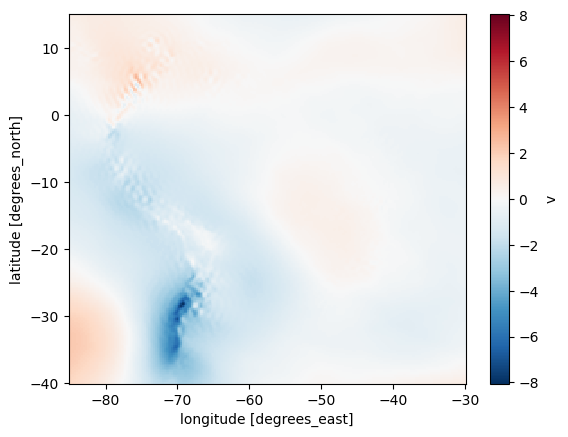

In [174]:
v_wind_era5_mean[1,:,:].where(v_wind_era5_mean[3,:,:] < 100).plot()

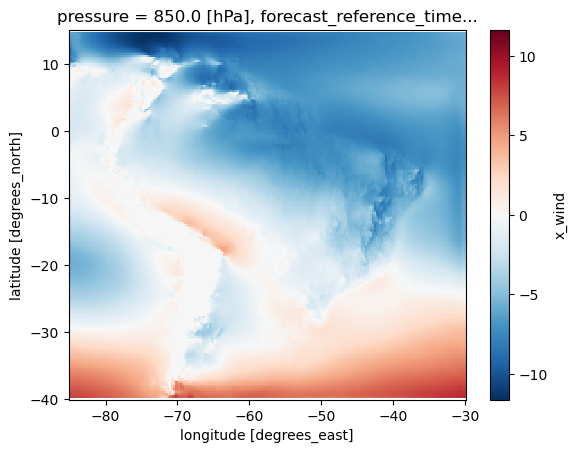

In [175]:
u_wind_hindcast_mean[3,:,:].where(u_wind_hindcast_mean[3,:,:] < 100).plot()

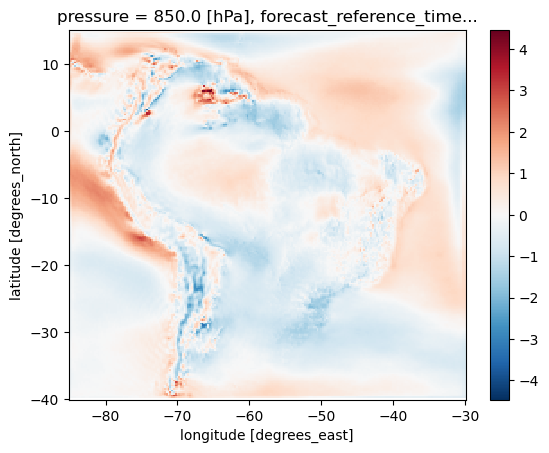

In [187]:
u_diff.sel(pressure=850).plot.pcolormesh()

In [163]:
import mpl_toolkits
from mpl_toolkits.basemap import Basemap

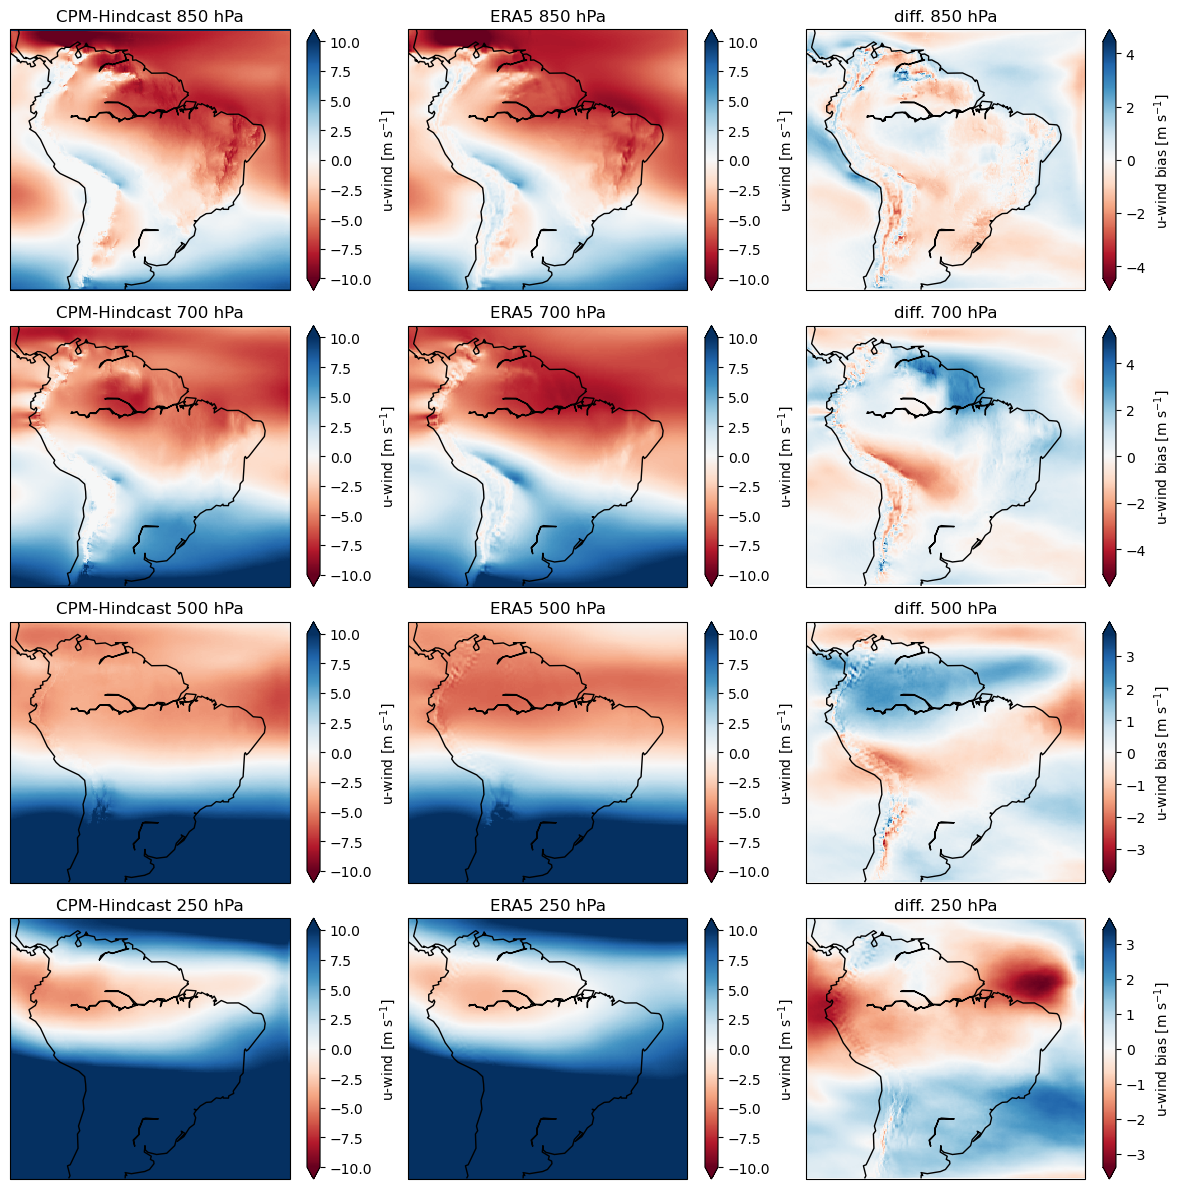

In [193]:
# Quick plot to show the results (https://docs.xarray.dev/en/stable/examples/monthly-means.html)
import matplotlib
matplotlib.rc_file_defaults()

# Irregular levels to illustrate the use of a proportional colorbar
# levels = [0, 10, 20, 30, 40, 50, 60, 70]
# levels_diff = [-30, -20, -10, 0, 10, 20, 30]

fig, geo_axes = plt.subplots(nrows=4, ncols=3, figsize=(12, 12), subplot_kw={'projection': ccrs.PlateCarree()})

m = Basemap(llcrnrlon=-85, llcrnrlat=-40,urcrnrlon=-30, urcrnrlat=15) # create Basemap object
m.drawcoastlines(linewidth=1, ax=geo_axes[0,0]) # draw coastlines
u_wind_hindcast_mean.sel(pressure=850).plot.pcolormesh(ax=geo_axes[0,0],vmin=-10,vmax=10,cmap="RdBu",add_colorbar=True,extend="both",cbar_kwargs={'label': 'u-wind [m s$^{-1}$]'})

m = Basemap(llcrnrlon=-85, llcrnrlat=-40,urcrnrlon=-30, urcrnrlat=15) # create Basemap object
m.drawcoastlines(linewidth=1, ax=geo_axes[0,1]) # draw coastlines
u_wind_era5_mean.sel(pressure=850).plot.pcolormesh(ax=geo_axes[0,1],vmin=-10,vmax=10,cmap="RdBu",add_colorbar=True,extend="both", cbar_kwargs={'label': 'u-wind [m s$^{-1}$]'})

m = Basemap(llcrnrlon=-85, llcrnrlat=-40,urcrnrlon=-30, urcrnrlat=15) # create Basemap object
m.drawcoastlines(linewidth=1, ax=geo_axes[0,2]) # draw coastlines
u_diff.sel(pressure=850).plot.pcolormesh(ax=geo_axes[0,2],cmap="RdBu",add_colorbar=True,extend="both", cbar_kwargs={'label': 'u-wind bias [m s$^{-1}$]'})

m = Basemap(llcrnrlon=-85, llcrnrlat=-40,urcrnrlon=-30, urcrnrlat=15) # create Basemap object
m.drawcoastlines(linewidth=1, ax=geo_axes[1,0]) # draw coastlines
u_wind_hindcast_mean.sel(pressure=700).plot.pcolormesh(ax=geo_axes[1,0],vmin=-10,vmax=10,cmap="RdBu",add_colorbar=True,extend="both",cbar_kwargs={'label': 'u-wind [m s$^{-1}$]'})

m = Basemap(llcrnrlon=-85, llcrnrlat=-40,urcrnrlon=-30, urcrnrlat=15) # create Basemap object
m.drawcoastlines(linewidth=1, ax=geo_axes[1,1]) # draw coastlines
u_wind_era5_mean.sel(pressure=700).plot.pcolormesh(ax=geo_axes[1,1],vmin=-10,vmax=10,cmap="RdBu",add_colorbar=True,extend="both",cbar_kwargs={'label': 'u-wind [m s$^{-1}$]'})

m = Basemap(llcrnrlon=-85, llcrnrlat=-40,urcrnrlon=-30, urcrnrlat=15) # create Basemap object
m.drawcoastlines(linewidth=1, ax=geo_axes[1,2]) # draw coastlines
u_diff.sel(pressure=700).plot.pcolormesh(ax=geo_axes[1,2],cmap="RdBu",add_colorbar=True,extend="both", cbar_kwargs={'label': 'u-wind bias [m s$^{-1}$]'})

m = Basemap(llcrnrlon=-85, llcrnrlat=-40,urcrnrlon=-30, urcrnrlat=15) # create Basemap object
m.drawcoastlines(linewidth=1, ax=geo_axes[2,0]) # draw coastlines
u_wind_hindcast_mean.sel(pressure=500).plot.pcolormesh(ax=geo_axes[2,0],vmin=-10,vmax=10,cmap="RdBu",add_colorbar=True,extend="both",cbar_kwargs={'label': 'u-wind [m s$^{-1}$]'})

m = Basemap(llcrnrlon=-85, llcrnrlat=-40,urcrnrlon=-30, urcrnrlat=15) # create Basemap object
m.drawcoastlines(linewidth=1, ax=geo_axes[2,1]) # draw coastlines
u_wind_era5_mean.sel(pressure=500).plot.pcolormesh(ax=geo_axes[2,1],vmin=-10,vmax=10,cmap="RdBu",add_colorbar=True,extend="both",cbar_kwargs={'label': 'u-wind [m s$^{-1}$]'})

m = Basemap(llcrnrlon=-85, llcrnrlat=-40,urcrnrlon=-30, urcrnrlat=15) # create Basemap object
m.drawcoastlines(linewidth=1, ax=geo_axes[2,2]) # draw coastlines
u_diff.sel(pressure=500).plot.pcolormesh(ax=geo_axes[2,2],cmap="RdBu",add_colorbar=True,extend="both", cbar_kwargs={'label': 'u-wind bias [m s$^{-1}$]'})

m = Basemap(llcrnrlon=-85, llcrnrlat=-40,urcrnrlon=-30, urcrnrlat=15) # create Basemap object
m.drawcoastlines(linewidth=1, ax=geo_axes[3,0]) # draw coastlines
u_wind_hindcast_mean.sel(pressure=250).plot.pcolormesh(ax=geo_axes[3,0],vmin=-10,vmax=10,cmap="RdBu",add_colorbar=True,extend="both",cbar_kwargs={'label': 'u-wind [m s$^{-1}$]'})

m = Basemap(llcrnrlon=-85, llcrnrlat=-40,urcrnrlon=-30, urcrnrlat=15) # create Basemap object
m.drawcoastlines(linewidth=1, ax=geo_axes[3,1]) # draw coastlines
u_wind_era5_mean.sel(pressure=250).plot.pcolormesh(ax=geo_axes[3,1],vmin=-10,vmax=10,cmap="RdBu",add_colorbar=True,extend="both",cbar_kwargs={'label': 'u-wind [m s$^{-1}$]'})

m = Basemap(llcrnrlon=-85, llcrnrlat=-40,urcrnrlon=-30, urcrnrlat=15) # create Basemap object
m.drawcoastlines(linewidth=1, ax=geo_axes[3,2]) # draw coastlines
u_diff.sel(pressure=250).plot.pcolormesh(ax=geo_axes[3,2],cmap="RdBu",add_colorbar=True,extend="both", cbar_kwargs={'label': 'u-wind bias [m s$^{-1}$]'})

for ax in geo_axes.flat:
    ax.axes.get_xaxis().set_ticklabels([])
    ax.axes.get_yaxis().set_ticklabels([])
    ax.axes.axis("tight")
    ax.set_xlabel("")
    ax.set_ylabel("")

geo_axes[0, 0].set_xlim(-85, -30)
geo_axes[0, 1].set_xlim(-85, -30)
geo_axes[0, 2].set_xlim(-85, -30)
geo_axes[1, 0].set_xlim(-85, -30)
geo_axes[1, 1].set_xlim(-85, -30)
geo_axes[1, 2].set_xlim(-85, -30)
geo_axes[2, 0].set_xlim(-85, -30)
geo_axes[2, 1].set_xlim(-85, -30)
geo_axes[2, 2].set_xlim(-85, -30)
geo_axes[3, 0].set_xlim(-85, -30)
geo_axes[3, 1].set_xlim(-85, -30)
geo_axes[3, 2].set_xlim(-85, -30)
    

geo_axes[0, 0].set_title("CPM-Hindcast 850 hPa")
geo_axes[0, 1].set_title("ERA5 850 hPa")
geo_axes[0, 2].set_title("diff. 850 hPa")
geo_axes[1, 0].set_title("CPM-Hindcast 700 hPa")
geo_axes[1, 1].set_title("ERA5 700 hPa")
geo_axes[1, 2].set_title("diff. 700 hPa")
geo_axes[2, 0].set_title("CPM-Hindcast 500 hPa")
geo_axes[2, 1].set_title("ERA5 500 hPa")
geo_axes[2, 2].set_title("diff. 500 hPa")
geo_axes[3, 0].set_title("CPM-Hindcast 250 hPa")
geo_axes[3, 1].set_title("ERA5 250 hPa")
geo_axes[3, 2].set_title("diff. 250 hPa")

#plt.suptitle('Mean monthly MCS contribution to precipitation (CPM-HINDCAST)')

plt.tight_layout()


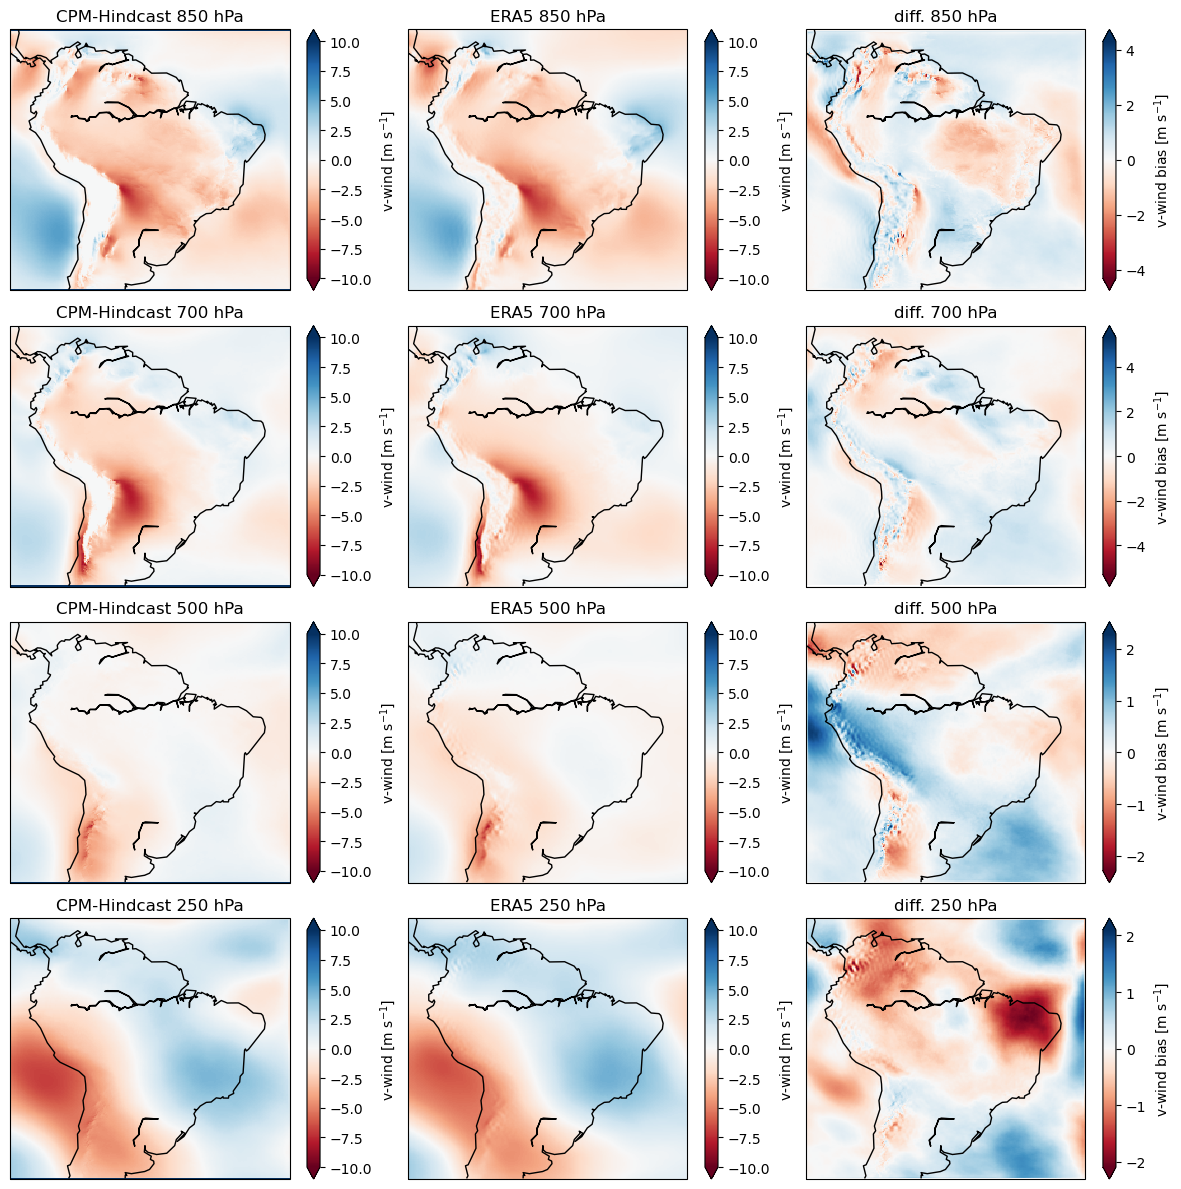

In [194]:
# Quick plot to show the results (https://docs.xarray.dev/en/stable/examples/monthly-means.html)
import matplotlib
matplotlib.rc_file_defaults()

# Irregular levels to illustrate the use of a proportional colorbar
# levels = [0, 10, 20, 30, 40, 50, 60, 70]
# levels_diff = [-30, -20, -10, 0, 10, 20, 30]

fig, geo_axes = plt.subplots(nrows=4, ncols=3, figsize=(12, 12), subplot_kw={'projection': ccrs.PlateCarree()})

m = Basemap(llcrnrlon=-85, llcrnrlat=-40,urcrnrlon=-30, urcrnrlat=15) # create Basemap object
m.drawcoastlines(linewidth=1, ax=geo_axes[0,0]) # draw coastlines
v_wind_hindcast_mean.sel(pressure=850).plot.pcolormesh(ax=geo_axes[0,0],vmin=-10,vmax=10,cmap="RdBu",add_colorbar=True,extend="both",cbar_kwargs={'label': 'v-wind [m s$^{-1}$]'})

m = Basemap(llcrnrlon=-85, llcrnrlat=-40,urcrnrlon=-30, urcrnrlat=15) # create Basemap object
m.drawcoastlines(linewidth=1, ax=geo_axes[0,1]) # draw coastlines
v_wind_era5_mean.sel(pressure=850).plot.pcolormesh(ax=geo_axes[0,1],vmin=-10,vmax=10,cmap="RdBu",add_colorbar=True,extend="both", cbar_kwargs={'label': 'v-wind [m s$^{-1}$]'})

m = Basemap(llcrnrlon=-85, llcrnrlat=-40,urcrnrlon=-30, urcrnrlat=15) # create Basemap object
m.drawcoastlines(linewidth=1, ax=geo_axes[0,2]) # draw coastlines
v_diff.sel(pressure=850).plot.pcolormesh(ax=geo_axes[0,2],cmap="RdBu",add_colorbar=True,extend="both", cbar_kwargs={'label': 'v-wind bias [m s$^{-1}$]'})

m = Basemap(llcrnrlon=-85, llcrnrlat=-40,urcrnrlon=-30, urcrnrlat=15) # create Basemap object
m.drawcoastlines(linewidth=1, ax=geo_axes[1,0]) # draw coastlines
v_wind_hindcast_mean.sel(pressure=700).plot.pcolormesh(ax=geo_axes[1,0],vmin=-10,vmax=10,cmap="RdBu",add_colorbar=True,extend="both",cbar_kwargs={'label': 'v-wind [m s$^{-1}$]'})

m = Basemap(llcrnrlon=-85, llcrnrlat=-40,urcrnrlon=-30, urcrnrlat=15) # create Basemap object
m.drawcoastlines(linewidth=1, ax=geo_axes[1,1]) # draw coastlines
v_wind_era5_mean.sel(pressure=700).plot.pcolormesh(ax=geo_axes[1,1],vmin=-10,vmax=10,cmap="RdBu",add_colorbar=True,extend="both",cbar_kwargs={'label': 'v-wind [m s$^{-1}$]'})

m = Basemap(llcrnrlon=-85, llcrnrlat=-40,urcrnrlon=-30, urcrnrlat=15) # create Basemap object
m.drawcoastlines(linewidth=1, ax=geo_axes[1,2]) # draw coastlines
v_diff.sel(pressure=700).plot.pcolormesh(ax=geo_axes[1,2],cmap="RdBu",add_colorbar=True,extend="both", cbar_kwargs={'label': 'v-wind bias [m s$^{-1}$]'})

m = Basemap(llcrnrlon=-85, llcrnrlat=-40,urcrnrlon=-30, urcrnrlat=15) # create Basemap object
m.drawcoastlines(linewidth=1, ax=geo_axes[2,0]) # draw coastlines
v_wind_hindcast_mean.sel(pressure=500).plot.pcolormesh(ax=geo_axes[2,0],vmin=-10,vmax=10,cmap="RdBu",add_colorbar=True,extend="both",cbar_kwargs={'label': 'v-wind [m s$^{-1}$]'})

m = Basemap(llcrnrlon=-85, llcrnrlat=-40,urcrnrlon=-30, urcrnrlat=15) # create Basemap object
m.drawcoastlines(linewidth=1, ax=geo_axes[2,1]) # draw coastlines
v_wind_era5_mean.sel(pressure=500).plot.pcolormesh(ax=geo_axes[2,1],vmin=-10,vmax=10,cmap="RdBu",add_colorbar=True,extend="both",cbar_kwargs={'label': 'v-wind [m s$^{-1}$]'})

m = Basemap(llcrnrlon=-85, llcrnrlat=-40,urcrnrlon=-30, urcrnrlat=15) # create Basemap object
m.drawcoastlines(linewidth=1, ax=geo_axes[2,2]) # draw coastlines
v_diff.sel(pressure=500).plot.pcolormesh(ax=geo_axes[2,2],cmap="RdBu",add_colorbar=True,extend="both", cbar_kwargs={'label': 'v-wind bias [m s$^{-1}$]'})

m = Basemap(llcrnrlon=-85, llcrnrlat=-40,urcrnrlon=-30, urcrnrlat=15) # create Basemap object
m.drawcoastlines(linewidth=1, ax=geo_axes[3,0]) # draw coastlines
v_wind_hindcast_mean.sel(pressure=250).plot.pcolormesh(ax=geo_axes[3,0],vmin=-10,vmax=10,cmap="RdBu",add_colorbar=True,extend="both",cbar_kwargs={'label': 'v-wind [m s$^{-1}$]'})

m = Basemap(llcrnrlon=-85, llcrnrlat=-40,urcrnrlon=-30, urcrnrlat=15) # create Basemap object
m.drawcoastlines(linewidth=1, ax=geo_axes[3,1]) # draw coastlines
v_wind_era5_mean.sel(pressure=250).plot.pcolormesh(ax=geo_axes[3,1],vmin=-10,vmax=10,cmap="RdBu",add_colorbar=True,extend="both",cbar_kwargs={'label': 'v-wind [m s$^{-1}$]'})

m = Basemap(llcrnrlon=-85, llcrnrlat=-40,urcrnrlon=-30, urcrnrlat=15) # create Basemap object
m.drawcoastlines(linewidth=1, ax=geo_axes[3,2]) # draw coastlines
v_diff.sel(pressure=250).plot.pcolormesh(ax=geo_axes[3,2],cmap="RdBu",add_colorbar=True,extend="both", cbar_kwargs={'label': 'v-wind bias [m s$^{-1}$]'})

for ax in geo_axes.flat:
    ax.axes.get_xaxis().set_ticklabels([])
    ax.axes.get_yaxis().set_ticklabels([])
    ax.axes.axis("tight")
    ax.set_xlabel("")
    ax.set_ylabel("")

geo_axes[0, 0].set_xlim(-85, -30)
geo_axes[0, 1].set_xlim(-85, -30)
geo_axes[0, 2].set_xlim(-85, -30)
geo_axes[1, 0].set_xlim(-85, -30)
geo_axes[1, 1].set_xlim(-85, -30)
geo_axes[1, 2].set_xlim(-85, -30)
geo_axes[2, 0].set_xlim(-85, -30)
geo_axes[2, 1].set_xlim(-85, -30)
geo_axes[2, 2].set_xlim(-85, -30)
geo_axes[3, 0].set_xlim(-85, -30)
geo_axes[3, 1].set_xlim(-85, -30)
geo_axes[3, 2].set_xlim(-85, -30)
    

geo_axes[0, 0].set_title("CPM-Hindcast 850 hPa")
geo_axes[0, 1].set_title("ERA5 850 hPa")
geo_axes[0, 2].set_title("diff. 850 hPa")
geo_axes[1, 0].set_title("CPM-Hindcast 700 hPa")
geo_axes[1, 1].set_title("ERA5 700 hPa")
geo_axes[1, 2].set_title("diff. 700 hPa")
geo_axes[2, 0].set_title("CPM-Hindcast 500 hPa")
geo_axes[2, 1].set_title("ERA5 500 hPa")
geo_axes[2, 2].set_title("diff. 500 hPa")
geo_axes[3, 0].set_title("CPM-Hindcast 250 hPa")
geo_axes[3, 1].set_title("ERA5 250 hPa")
geo_axes[3, 2].set_title("diff. 250 hPa")

#plt.suptitle('Mean monthly MCS contribution to precipitation (CPM-HINDCAST)')

plt.tight_layout()
